In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from sklearn.model_selection import train_test_split
from scipy.io import savemat, loadmat
import pylab as plt
import numpy as np
from scipy.spatial.distance import cdist
from IPython.display import clear_output
import ipywidgets as ipw
import scipy.ndimage as ndimage
from scipy.interpolate import RegularGridInterpolator
import timeit
import sys
from scipy.ndimage import gaussian_filter
from tqdm import tqdm_notebook

In [3]:
sys.path.append('../../')

In [4]:
import src.approximation as appr
from src import ml_utils
from src.openst import OpenST as ost
from src import plot_utils

Using TensorFlow backend.


In [5]:
def data_input_layered():
    data = loadmat('../data/layered_traveltimes.mat')
    vp = loadmat('../data/layered_model.mat')['vp'].T
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def data_input_seg():
    data = loadmat('../data/seg_traveltimes.mat')
    vp = data['SpeedImage'][:,0,:]
    time = data['time']
    sou = np.stack([np.float32(data['SX']), np.float32(data['SZ'])], axis=-1)
    rec = np.stack([np.float32(data['SX'][:,0]), np.float32(data['SX'][0,:])]).T
    return sou, rec, time, vp

def init_interpolation(sou, rec, time):
    x = rec[:,0]
    y = sou[0,:,1]
    z = sou[:,0,0]
    assert len(time.shape)>2 and time.shape[0]==rec.shape[0]
    
    return RegularGridInterpolator((x, y, z), time, method='linear', bounds_error=False, fill_value=None)

def get_bytes(ns, nr, byte=8):
    print('1 float value: {0} bytes'.format(byte))
    print('For {0} sources and {1} receivers:'.format(ns, nr))
    b = float(nr) * float(ns) * float(byte)
    kb = b / 1024
    mb = kb / 1024
    gb = mb / 1024
    print('{0:.2f} bytes'.format(b))
    print('{0:.2f} Kbytes\t{1:.2f} Mbytes\t{2:.2f} Gbytes'.format(kb, mb, gb))

In [6]:
dx, dy, dz = 22*1.25, 22*1.25, 22*1.25
nx, nz = 128, 128
ny = nx
x = np.linspace(0, (nx - 1) * dx, nx)
y = np.linspace(0, (ny - 1) * dy, ny)
z = np.linspace(0, (nz - 1) * dz, nz)

In [7]:
V_3d = np.load('../../data/approximation/marmousi_for_3d.npy')

In [ ]:
fig = plt.figure(figsize=(6,6), dpi=315)
fs = 22
ax = fig.add_subplot(111)
ax.set_title('Y = 1925 m', fontsize=fs)
im = ax.imshow(V_3d.T / 1000, extent=(0, x.max() / 1000, z.max() / 1000, 0))
ax.plot(1.925, 1.925, 'r*', ms=25, fillstyle='none', markeredgewidth=2, label='source location')
ax.set_xlabel('Distance (km)', fontsize=fs)
ax.set_ylabel('Depth (km)', fontsize=fs)
ax.tick_params(labelsize=fs)
plt.legend(loc='lower left', fontsize=18)

cbar = plt.colorbar(mappable=im, ax=ax, fraction=1/22.2)
cbar.set_label(label='Velocity (km/s)', fontsize=fs)
cbar.ax.tick_params(labelsize=fs)
ax.axis('scaled')

plt.show()

In [15]:
np.where(x==1925)

(array([70], dtype=int64),)

In [36]:
scaler_x = ml_utils.Scaler(x)
scaler_y = ml_utils.Scaler(y)
scaler_z = ml_utils.Scaler(z)
x_sc = scaler_x.scale(x)
y_sc = scaler_x.scale(y)
z_sc = scaler_x.scale(z)

In [39]:
Approximator = appr.Approximator(num_layers=1, num_units=[2000], num_inputs=5, output_dim=1, 
#                                  input_scalers=[scaler_x, scaler_y, scaler_x, scaler_y, scaler_z],
                                )
Approximator.description


{'num_layers': 1,
 'num_units': [2000],
 'activations': ['relu'],
 'initializations': ['random_normal'],
 'biases': [True],
 'input_dim': 1,
 'output_dim': 1,
 'num_inputs': 5,
 'input_names': ['input_0', 'input_1', 'input_2', 'input_3', 'input_4']}

In [11]:
train_times = np.load('C:/users/grubassi/data/marmousi3D/train_times-10-10-10.npy')

In [42]:
train_set = appr.Approximator.prepare_inputs(inputs=[x_sc, y_sc, x_sc, y_sc, z_sc], outputs=train_times[..., None], 
                                                        flatenned=False, sparse=[1, 1, 10, 10, 10])

In [14]:
import keras

early = keras.callbacks.EarlyStopping(monitor='mae', min_delta=1e-8, patience=4, verbose=2, 
                                      mode='auto', baseline=None, restore_best_weights=False)

reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)

callbacks = [reducer, early]

In [43]:
adam = keras.optimizers.Adam(lr=1e-3, decay=1e-4, amsgrad=False)
Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])

In [44]:
Approximator.nn_model.fit(x=train_set[0], y=train_times.ravel(), 
                          shuffle=True, 
                          batch_size=1024,
                          epochs=120,
                          verbose=1, 
                          callbacks=callbacks)

Epoch 1/120
  124928/35995648 [..............................] - ETA: 41:23:39 - loss: 1.4542e-05 - mae: 0.002 - ETA: 13:58:57 - loss: 0.0127 - mae: 0.0728    - ETA: 8:30:22 - loss: 0.0140 - mae: 0.090 - ETA: 6:09:07 - loss: 0.0124 - mae: 0.08 - ETA: 4:51:07 - loss: 0.0106 - mae: 0.07 - ETA: 4:01:06 - loss: 0.0104 - mae: 0.08 - ETA: 3:26:41 - loss: 0.0091 - mae: 0.07 - ETA: 3:01:14 - loss: 0.0083 - mae: 0.07 - ETA: 2:33:21 - loss: 0.0075 - mae: 0.06 - ETA: 2:13:26 - loss: 0.0067 - mae: 0.06 - ETA: 2:03:10 - loss: 0.0063 - mae: 0.06 - ETA: 1:54:30 - loss: 0.0058 - mae: 0.05 - ETA: 1:47:13 - loss: 0.0055 - mae: 0.05 - ETA: 1:40:53 - loss: 0.0052 - mae: 0.05 - ETA: 1:35:22 - loss: 0.0049 - mae: 0.05 - ETA: 1:30:35 - loss: 0.0046 - mae: 0.04 - ETA: 1:26:17 - loss: 0.0044 - mae: 0.04 - ETA: 1:22:31 - loss: 0.0042 - mae: 0.04 - ETA: 1:17:23 - loss: 0.0039 - mae: 0.04 - ETA: 1:12:57 - loss: 0.0036 - mae: 0.04 - ETA: 1:09:01 - loss: 0.0034 - mae: 0.03 - ETA: 1:05:37 - loss: 0.0032 - mae: 0.03 

KeyboardInterrupt: 

In [41]:
Approximator.nn_model.save('../../nn_models/approximation/marmousi3D_10-10-10')

In [37]:
weights = Approximator.nn_model.get_weights()

In [40]:
Approximator.nn_model.set_weights(weights)

In [8]:
%%time
T = np.empty((nx, nx, nz), dtype=float)
with tqdm_notebook(total=nx, desc='FSM calculation') as p_bar:
    for i in range(nx):
        src = np.array([x[i], 0.0])
        T[i] = ost.LSM2D(V, CoordLimLow, CoordLimHigh, GridStep, src)
        p_bar.update()


Wall time: 2min 50s


In [ ]:
plt.figure(figsize=(30,15))

levels = np.linspace(0, T[0].max(), 12)
plt.imshow(V.T, extent=(0, xmax, zmax, 0))
plt.contour(T[0].T, levels=levels, colors='k', linewidths=3, extent=(0, xmax, 0, zmax))
plt.ylim([zmax, 0])
plt.axis('scaled')

plt.show()

In [9]:
sou_x = x.copy()
sou_z = z.copy()
rec_x = x.copy()
t_scaler = T.max()
t_sc = T[..., None] / t_scaler
t_sc_train = t_sc[:, ::10, ::10]

x_scaler = ml_utils.Scaler(x)
z_scaler = ml_utils.Scaler(z)
sou_x_sc = x_scaler.scale(sou_x, verbose=True)
sou_z_sc = z_scaler.scale(sou_z, verbose=True)
rec_x_sc = x_scaler.scale(rec_x)

Before scaling:
Mean: 8500.0	Std: 4911.08
After scaling:
Mean: 0.0	Std: 1.0
Before scaling:
Mean: 1750.0	Std: 1013.96
After scaling:
Mean: 0.0	Std: 1.0


In [10]:
batches_input, batches_output = [], []
sx = [100, 80, 60, 40, 20, 10, 8, 6, 4, 2]
sz = sx
for s1, s2 in zip(sx, sz):
    i, o = appr.Approximator.prepare_inputs(inputs=[rec_x_sc, sou_x_sc, sou_z_sc], outputs=T[...,None], 
                                                flatenned=False, sparse=[1,s1,s2],)
    batches_input.append(i)
    batches_output.append(o)

In [35]:
Xr, Xs, Zs = np.meshgrid(rec_x_sc, sou_x_sc[::2], sou_z_sc[::2], indexing='ij')
inputs = [Xr.ravel(), Xs.ravel(), Zs.ravel()]
names = ['input_0', 'input_1', 'input_2']
input_test = {kw:v for kw, v in zip(names, inputs)}

In [81]:
Approximator = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)
Approximator.description

{'num_layers': 1,
 'num_units': [2500],
 'activations': ['relu'],
 'initializations': ['random_normal'],
 'biases': [True],
 'input_dim': 1,
 'output_dim': 1,
 'num_inputs': 3,
 'input_names': ['input_0', 'input_1', 'input_2']}

In [ ]:
Approximator.nn_model.summary()

In [13]:
from keras import optimizers
import keras
import keras.backend as K

In [54]:
general_model = keras.models.load_model('../../nn_models/general_approximator', compile=False)

In [14]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4, amsgrad=False)
Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='mean_absolute_error', min_delta=1e-8, patience=4, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-8, cooldown=0, min_lr=1e-7)
callbacks = [
#             plot_losses, 
            early,
            reducer,
            ]

W0120 14:51:30.632324 14240 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [16]:
%%time
histories = []
epochs = [100, 100, 80, 80, 60, 60, 40, 40, 20, 20]
for i in range(len(epochs)):
    Approximator = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)
    Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=['mae'])
    histories += [Approximator.nn_model.fit(x=batches_input[i], y=batches_output[i],
                         batch_size=128*(i+1),
                         epochs=epochs[i],
#                          validation_data=(input_valid, output_valid),
                         verbose=2,
                          shuffle=True,
                             callbacks=callbacks,
                         )]
    Approximator.nn_model.save('../../nn_models/approximation/marmousi_step{}'.format(sx[i]))

Epoch 1/100
 - 3s - loss: 2.8295 - mean_absolute_error: 1.3711
Epoch 2/100
 - 3s - loss: 0.6852 - mean_absolute_error: 0.6690
Epoch 3/100
 - 2s - loss: 0.3616 - mean_absolute_error: 0.4512
Epoch 4/100
 - 2s - loss: 0.2346 - mean_absolute_error: 0.3505
Epoch 5/100
 - 2s - loss: 0.1841 - mean_absolute_error: 0.3108
Epoch 6/100
 - 2s - loss: 0.1593 - mean_absolute_error: 0.2911
Epoch 7/100
 - 2s - loss: 0.1414 - mean_absolute_error: 0.2751
Epoch 8/100
 - 2s - loss: 0.1262 - mean_absolute_error: 0.2605
Epoch 9/100
 - 2s - loss: 0.1125 - mean_absolute_error: 0.2457
Epoch 10/100
 - 2s - loss: 0.1001 - mean_absolute_error: 0.2309
Epoch 11/100
 - 2s - loss: 0.0886 - mean_absolute_error: 0.2163
Epoch 12/100
 - 2s - loss: 0.0781 - mean_absolute_error: 0.2017
Epoch 13/100
 - 2s - loss: 0.0684 - mean_absolute_error: 0.1878
Epoch 14/100
 - 2s - loss: 0.0596 - mean_absolute_error: 0.1739
Epoch 15/100
 - 2s - loss: 0.0516 - mean_absolute_error: 0.1603
Epoch 16/100
 - 2s - loss: 0.0444 - mean_absolute

Epoch 27/100
 - 3s - loss: 0.0220 - mean_absolute_error: 0.1008
Epoch 28/100
 - 3s - loss: 0.0194 - mean_absolute_error: 0.0952
Epoch 29/100
 - 3s - loss: 0.0171 - mean_absolute_error: 0.0901
Epoch 30/100
 - 3s - loss: 0.0151 - mean_absolute_error: 0.0854
Epoch 31/100
 - 3s - loss: 0.0134 - mean_absolute_error: 0.0811
Epoch 32/100
 - 3s - loss: 0.0118 - mean_absolute_error: 0.0771
Epoch 33/100
 - 3s - loss: 0.0105 - mean_absolute_error: 0.0733
Epoch 34/100
 - 3s - loss: 0.0094 - mean_absolute_error: 0.0699
Epoch 35/100
 - 3s - loss: 0.0084 - mean_absolute_error: 0.0668
Epoch 36/100
 - 3s - loss: 0.0076 - mean_absolute_error: 0.0639
Epoch 37/100
 - 3s - loss: 0.0068 - mean_absolute_error: 0.0612
Epoch 38/100
 - 3s - loss: 0.0062 - mean_absolute_error: 0.0587
Epoch 39/100
 - 3s - loss: 0.0056 - mean_absolute_error: 0.0564
Epoch 40/100
 - 3s - loss: 0.0051 - mean_absolute_error: 0.0542
Epoch 41/100
 - 3s - loss: 0.0047 - mean_absolute_error: 0.0522
Epoch 42/100
 - 3s - loss: 0.0043 - mean

Epoch 54/80
 - 3s - loss: 0.0018 - mean_absolute_error: 0.0329
Epoch 55/80
 - 3s - loss: 0.0017 - mean_absolute_error: 0.0320
Epoch 56/80
 - 3s - loss: 0.0016 - mean_absolute_error: 0.0312
Epoch 57/80
 - 3s - loss: 0.0015 - mean_absolute_error: 0.0304
Epoch 58/80
 - 3s - loss: 0.0015 - mean_absolute_error: 0.0297
Epoch 59/80
 - 3s - loss: 0.0014 - mean_absolute_error: 0.0290
Epoch 60/80
 - 3s - loss: 0.0013 - mean_absolute_error: 0.0284
Epoch 61/80
 - 3s - loss: 0.0013 - mean_absolute_error: 0.0278
Epoch 62/80
 - 3s - loss: 0.0013 - mean_absolute_error: 0.0272
Epoch 63/80
 - 3s - loss: 0.0012 - mean_absolute_error: 0.0267
Epoch 64/80
 - 3s - loss: 0.0012 - mean_absolute_error: 0.0262
Epoch 65/80
 - 3s - loss: 0.0011 - mean_absolute_error: 0.0257
Epoch 66/80
 - 3s - loss: 0.0011 - mean_absolute_error: 0.0252
Epoch 67/80
 - 3s - loss: 0.0011 - mean_absolute_error: 0.0248
Epoch 68/80
 - 3s - loss: 0.0010 - mean_absolute_error: 0.0244
Epoch 69/80
 - 3s - loss: 0.0010 - mean_absolute_error:

Epoch 21/60
 - 28s - loss: 7.7539e-04 - mean_absolute_error: 0.0207
Epoch 22/60
 - 28s - loss: 7.4079e-04 - mean_absolute_error: 0.0202
Epoch 23/60
 - 28s - loss: 7.1008e-04 - mean_absolute_error: 0.0197
Epoch 24/60
 - 28s - loss: 6.8274e-04 - mean_absolute_error: 0.0193
Epoch 25/60
 - 29s - loss: 6.5810e-04 - mean_absolute_error: 0.0189
Epoch 26/60
 - 28s - loss: 6.3496e-04 - mean_absolute_error: 0.0186
Epoch 27/60
 - 28s - loss: 6.1217e-04 - mean_absolute_error: 0.0182
Epoch 28/60
 - 28s - loss: 5.9023e-04 - mean_absolute_error: 0.0179
Epoch 29/60
 - 29s - loss: 5.7014e-04 - mean_absolute_error: 0.0176
Epoch 30/60
 - 28s - loss: 5.5204e-04 - mean_absolute_error: 0.0173
Epoch 31/60
 - 28s - loss: 5.3471e-04 - mean_absolute_error: 0.0170
Epoch 32/60
 - 27s - loss: 5.1851e-04 - mean_absolute_error: 0.0168
Epoch 33/60
 - 27s - loss: 5.0374e-04 - mean_absolute_error: 0.0165
Epoch 34/60
 - 27s - loss: 4.9041e-04 - mean_absolute_error: 0.0163
Epoch 35/60
 - 26s - loss: 4.7786e-04 - mean_abs

Epoch 23/40
 - 136s - loss: 3.6591e-04 - mean_absolute_error: 0.0141
Epoch 24/40
 - 135s - loss: 3.5414e-04 - mean_absolute_error: 0.0139
Epoch 25/40
 - 138s - loss: 3.4294e-04 - mean_absolute_error: 0.0137
Epoch 26/40
 - 138s - loss: 3.3231e-04 - mean_absolute_error: 0.0135
Epoch 27/40
 - 137s - loss: 3.2262e-04 - mean_absolute_error: 0.0133
Epoch 28/40
 - 139s - loss: 3.1383e-04 - mean_absolute_error: 0.0131
Epoch 29/40
 - 136s - loss: 3.0596e-04 - mean_absolute_error: 0.0129
Epoch 30/40
 - 138s - loss: 2.9875e-04 - mean_absolute_error: 0.0128
Epoch 31/40
 - 134s - loss: 2.9190e-04 - mean_absolute_error: 0.0126
Epoch 32/40
 - 136s - loss: 2.8523e-04 - mean_absolute_error: 0.0125
Epoch 33/40
 - 137s - loss: 2.7893e-04 - mean_absolute_error: 0.0123
Epoch 34/40
 - 138s - loss: 2.7295e-04 - mean_absolute_error: 0.0122
Epoch 35/40
 - 136s - loss: 2.6737e-04 - mean_absolute_error: 0.0121
Epoch 36/40
 - 138s - loss: 2.6218e-04 - mean_absolute_error: 0.0120
Epoch 37/40
 - 138s - loss: 2.5733

In [28]:
Approximator.nn_model.save('../../nn_models/approximation/marmousi')

In [39]:
T_pred = Approximator.nn_model.predict(input_test, batch_size=5000, verbose=2)

In [49]:
AE = abs(T_pred - T[:,::2,::2])
MAE = AE.mean()
MAE

0.008484843057165625

In [80]:
T.shape[0]**2 * T.shape[-1] / 201**3 

64.0965121916469

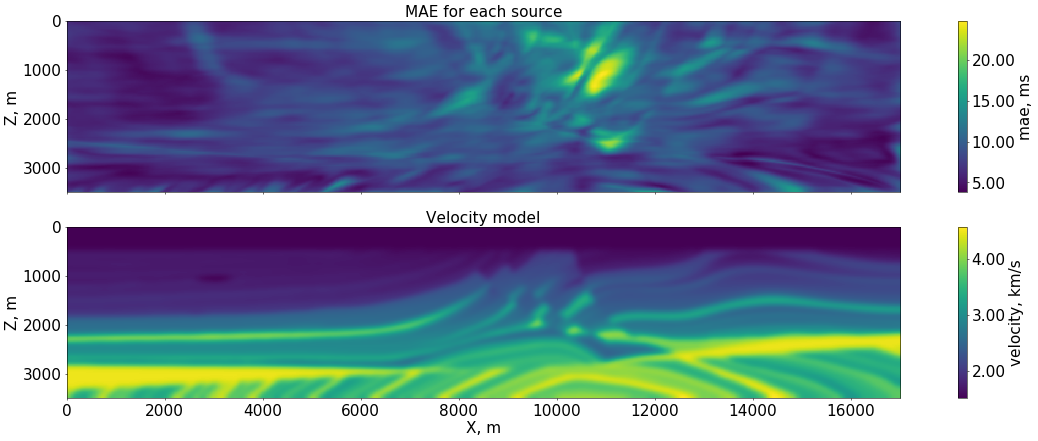

In [72]:
extent = (0, xmax, 0, zmax)
figsize = (30, 10)
colorbars = True
fontsize = 22
cbar_labels = [['mae, ms'],['velocity, km/s']]
fig, axes = plot_utils.plot_images(imgs=[[AE.mean(axis=0).T*1000], [V.T/1000]], cols_names=[['MAE for each source'],['Velocity model']], 
                                   imshows=True, figsize=figsize, extent=extent, colorbars=True, cbar_labels=cbar_labels, fontsize=fontsize)
plt.show()

In [45]:
%%time
T_pred = T_pred.reshape(T[:,::2,::2].shape)

Wall time: 0 ns


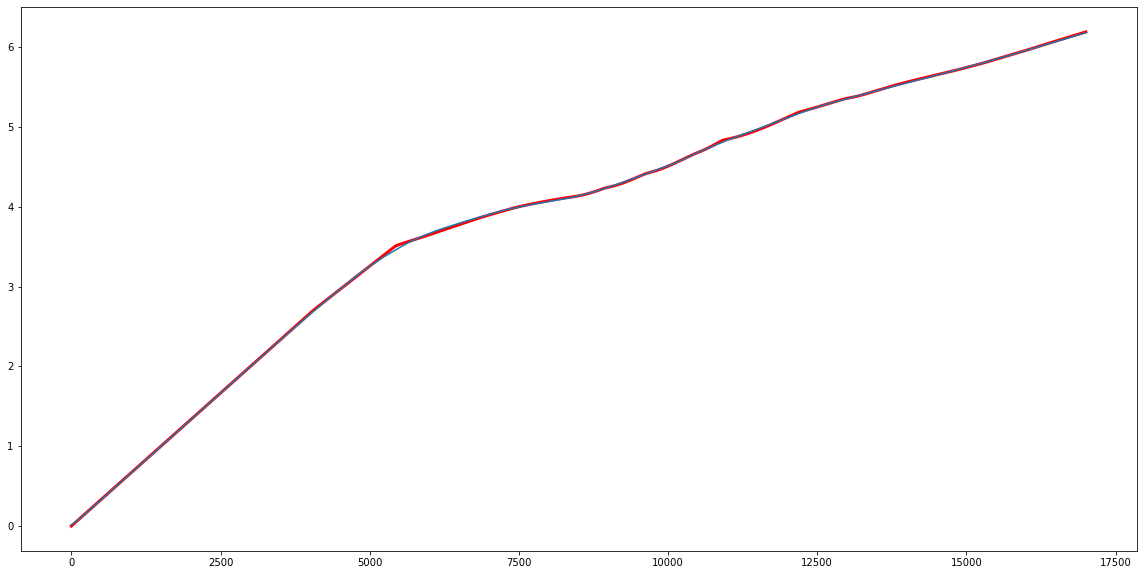

In [48]:
Nx, Nz = 0, 0
plt.figure(figsize=(20,10))
plt.plot(x, T[:,::2,::2][:, Nx, Nz], 'r', lw=3)
plt.plot(x, T_pred[:, Nx, Nz])

<hr>

In [ ]:
%%time
Approximator.nn_model.fit(x=input_train, y=output_train,
                         batch_size=2048,
                         epochs=1000,
#                          validation_data=(input_valid, output_valid),
                         verbose=1,
                          shuffle=True,
                         callbacks=callbacks,
                         )

In [ ]:
input_test, output_test = Approximator.prepare_inputs(inputs=[rec_x, sou_x, sou_z], outputs=output, 
                                                        flatenned=False, sparse=[1,1,1])

In [ ]:
predicted_test = Approximator.nn_model.predict(input_test)

In [ ]:
rel_test = output_test.copy()
rel_test[output_test == 0.0] = 1

AE = (abs(output_test.ravel() - predicted_test.ravel()))
print('MAE: ', AE.mean())
print('MAE: {} %'.format(np.nanmean(AE / rel_test.ravel() * 100)))

<hr>

### Saving trained NN model to tensorflow pb file

In [ ]:
# save model to pb
import tensorflow as tf
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = convert_variables_to_constants(session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph
    
# save keras model as tf pb files
from keras import backend as K
frozen_graph = freeze_session(K.get_session(), 
                              output_names=[out.op.name for out in Approximator.nn_model.outputs])
pb_filename = 'trained_nn_layered'
wkdir = '../nn_models'
tf.train.write_graph(frozen_graph, wkdir, pb_filename, as_text=False)

### Import trained model from pb

In [ ]:
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    # load model from pb file
    with gfile.FastGFile(wkdir + '/' + pb_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        sess.graph.as_default()
        g_in = tf.import_graph_def(graph_def)

In [ ]:
# write to tensorboard (check tensorboard for each op names)
writer = tf.summary.FileWriter(wkdir + '/log/')
writer.add_graph(sess.graph)
writer.flush()
writer.close()

In [ ]:
Approximator.nn_model.summary()

In [ ]:
# print all operation names
for op in sess.graph.get_operations():
    print(op)

In [ ]:
# inference by the model (op name must comes with :0 to specify the index of its output)
tensor_output = sess.graph.get_tensor_by_name('import/dense_3/BiasAdd:0')

tensor_input_0 = sess.graph.get_tensor_by_name('import/input_0:0')
tensor_input_1 = sess.graph.get_tensor_by_name('import/input_1:0')
tensor_input_2 = sess.graph.get_tensor_by_name('import/input_2:0')

# [..., None] - reshape from (...,) to (..., 1)
inputs = {tensor_input_0: input_test['input_0'][...,None], # input_0 - Координата приемника Х
          tensor_input_1: input_test['input_1'][...,None], # input_1 - Координата источника Х
          tensor_input_2: input_test['input_2'][...,None]} # input_2 - Координата источника Z

with tf.Session() as sess:
    predictions = sess.run(tensor_output, inputs)
print(predictions)

In [ ]:
AE_of_pb = (abs(output_test.ravel() - predictions.ravel()))
print('MAE: ', AE_of_pb.mean())
print('MAE: {} %'.format((AE_of_pb / rel_test.ravel() * 100).mean()))

## Model generation

In [ ]:
def gauss(x, mu, sigma):
    e = np.exp(-(x - mu)**2 / (2 * sigma**2))
    return e / e.max()

def sigmoid(x, mu, sigma):
    s = 1 / (1 + np.exp(-(x - mu) / sigma))
    return s

def p_gauss(x, mu, sigmas, scale):
    assert len(sigmas) == 2
    
    g = np.zeros((len(sigmas), len(x)))
    for i, sigma in enumerate(sigmas):
        g[i] = gauss(x, mu, sigma)
    
    g[1] *= scale
    g[1] += g[0].max() - g[1].max()
    i_max = np.argmax(g[0])
    G = np.hstack((g[0, :i_max], g[1, i_max:]))
    return G
    

def generator_velocity_models(x, z, vmin, vmax, noise_n, noise_level=None, smooth=False, smoothing=1, layers=False, max_layers=None, 
                              structure_map=None, structure_n=None, locals_map=None, locals_n=None):
    X, Z = np.meshgrid(x, z, indexing='ij')
    nx, nz = len(x), len(z)
    v_grad = np.linspace(vmin, vmax, nz)[None, ...]
    mu = z.mean()
    sigma = (mu - z.min()) / 2
    noise_z = p_gauss(z, mu, [sigma, sigma*1.2], 0.5)
    if noise_level is None:
        noise_level = (v_grad.mean() - vmin) / 4
    
    V_grad = np.zeros((noise_n, nx, nz))
    V = np.zeros((noise_n, nz))
    for i in range(noise_n):

        noise_grad = noise_level * np.random.randn(nz) * noise_z
        vi = v_grad + noise_grad
        vi[vi < vmin] = v_grad[vi < vmin]
        
        if layers == True:
            if max_layers is None:
                max_layers = 10
            layers_n = np.random.binomial(max_layers, 0.5, 1)
            n, nn = int(nz // layers_n), int(nz % layers_n)
            l_d = abs(np.random.normal(loc=1.0, scale=1/6, size=layers_n))
            multiply = np.repeat(l_d, n)
            multiply = np.hstack((multiply, np.repeat(multiply[-1:], nn)))
            vi *= multiply
            
        if smooth:
            vi = gaussian_filter(vi, smoothing)
        V[i] = vi
        V_grad[i] = np.repeat(vi, nx, axis=0)
    
    return V, V_grad

In [ ]:
xmin, xmax = 0, 2000
zmin, zmax = 0, 2000
nx, nz = 201, 201
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
N = 25

vmin, vmax = 1000.0, 5000.0
V, V_grad = generator_velocity_models(x, z, vmin, vmax, N, noise_level=250.0, smooth=True, smoothing=0.5, layers=True)

In [ ]:
plt.figure(figsize=(15,7))

plt.plot(z, V.T)
plt.plot(z, np.linspace(vmin, vmax, nz), 'k', ms=3)

plt.show()

In [ ]:
ncols = 10
nrows = int(np.ceil(N / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 9), squeeze=False)

for i in range(0,nrows):
    for j in range(0,ncols):
        k = i * ncols + j
        try:
            axes[i,j].imshow(V_grad[k].T)
            axes[i,j].axis('equal')
        except:
            pass
plt.show()

In [ ]:
src = np.array([xmin, zmax])
Min = np.array([xmin, zmin])
Max = np.array([xmax, zmax])
steps = np.array([x[1]-x[0], z[1] - z[0]])

T = np.zeros((N, nx, nz))
for i in range(N):
    T[i] = ost.LSM2D(V_grad[i], Min, Max, steps, src)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(x, T[:, :, 0].T)
plt.show()

In [ ]:
xmin, xmax = 0, 2000
zmin, zmax = 0, 2000
nx, nz = 31, 31
x = np.linspace(xmin, xmax, nx)
z = np.linspace(zmin, zmax, nz)
N = 25

vmin, vmax = 1000.0, 5000.0
V, V_grad = generator_velocity_models(x, z, vmin, vmax, N, noise_level=250.0, smooth=True, smoothing=0.5, layers=True)

In [ ]:
Min = np.array([xmin, zmin])
Max = np.array([xmax, zmax])
steps = np.array([x[1]-x[0], z[1] - z[0]])


T = np.zeros((N, nx, nx, nz))
with tqdm_notebook(total=N*nx, desc='FSM calc') as p_bar:
    for j in range(nx):
        src = np.array([x[j], 0.0])
        for i in range(N):
            T[i,j] = ost.LSM2D(V_grad[i], Min, Max, steps, src)
            p_bar.update()

In [ ]:
scaler_x = ml_utils.Scaler(x)
scaler_z = ml_utils.Scaler(z)

rec_x_sc = scaler_x.scale(x)
sou_x_sc = scaler_x.scale(x)
sou_z_sc = scaler_z.scale(z)

scaler_t = T.max(axis=(1,2,3), keepdims=True)
t_sc = T / scaler_t

In [ ]:
Xr, Xs, Zs = np.meshgrid(rec_x_sc, sou_x_sc, sou_z_sc, indexing='ij')
Xr_g = np.repeat(Xr[None, ...], N, axis=0)
Xs_g = np.repeat(Xs[None, ...], N, axis=0)
Zs_g = np.repeat(Zs[None, ...], N, axis=0)

In [ ]:
inputs = [Xr_g.ravel(), Xs_g.ravel(), Zs_g.ravel()]
names = ['input_0', 'input_1', 'input_2']
input_train = {kw:v for kw, v in zip(names, inputs)}

In [ ]:
Approximator = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)
Approximator.description

In [ ]:
from keras import optimizers
import keras
import keras.backend as K

In [ ]:
adam = optimizers.Adam(lr=1e-3, decay=1e-4)
Approximator.nn_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=4, verbose=2, 
                                      mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, verbose=1, 
                                            mode='auto', min_delta=1e-5, cooldown=0, min_lr=1e-6)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = Approximator.nn_model.fit(x=input_train, y=t_sc.ravel(),
                     batch_size=256,
                     epochs=25,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                      shuffle=True,
                         callbacks=callbacks,
                     )

In [ ]:
Approximator.nn_model.save('../nn_models/general_approximator')

In [ ]:
test = [Xr.ravel(), Xs.ravel(), Zs.ravel()]
input_test = {kw:v for kw, v in zip(names, test)}

In [ ]:
pred_t = Approximator.nn_model.predict(input_test).reshape(nx, nx, nz)

In [ ]:
xi, zi = 15, 1
plt.figure(figsize=(15,5))
plt.plot(x, t_sc[:, :, xi, zi].T)
plt.plot(x, pred_t[:, xi, zi], 'k', lw=3)
plt.show()

## Transfer general model to a particular case

In [ ]:
general_model = keras.models.load_model('../nn_models/general_approximator', compile=False)

In [ ]:
adam = optimizers.Adam(lr=5e-4, decay=0, amsgrad=True)
general_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=5, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=4, verbose=1, 
                                                      mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = general_model.fit(x=input_test, y=t_sc[0].ravel(),
                     batch_size=128,
                     epochs=100,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                     shuffle=True,
#                      callbacks=callbacks,
                     )

In [ ]:
new_appr = appr.Approximator(num_layers=1, num_units=[1500], num_inputs=3, output_dim=1)

In [ ]:
adam = optimizers.Adam(lr=5e-4, decay=0, amsgrad=True)
new_appr.nn_model.compile(optimizer=adam, loss='mse', metrics=[metric(scaler_t[0])])
plot_losses = ml_utils.PlotLosses()
early = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-9, patience=5, verbose=2, 
                                        mode='auto', baseline=None, restore_best_weights=False)
reducer = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.75, patience=4, verbose=1, 
                                                      mode='auto', min_delta=1e-9, cooldown=1, min_lr=1e-7)

callbacks = [
#             plot_losses, 
#             early,
            reducer
            ]

In [ ]:
%%time
history = new_appr.nn_model.fit(x=input_test, y=t_sc[0].ravel(),
                     batch_size=128,
                     epochs=100,
#                          validation_data=(input_valid, output_valid),
                     verbose=2,
                     shuffle=True,
#                      callbacks=callbacks,
                     )